┌───────────────────────────────┐
│ M Z Y E M Y S T E R Y G S S C │
│ I E I S E Z T K A K V A T O O │
│ S N M C X C C D E X Y M R L D │
│ S C M A I L O E S Y I E A V E │
│ I I E P C U U D U O N M T E S │
│ O R R E A E N U S R S A E C O │
│ N C S G N S T C P K A S G H O │
│ C U I A C E D T E E N T Y A U │
│ P R V M A C O I N N E E H L T │
│ U S E E R R W O S I A R I L B │
│ Z E L N T E N N E G S T D E R │
│ Z R O I E T F M Y M Y I D N E │
│ L O C G L S M I N A L M E G A │
│ E O K H T H E M E O U E N E K │
│ T M S T R I D D L E M R A U R │
└───────────────────────────────┘
┌───────────────────────────────┐
│     Y                         │
│           Z T   A K V         │
│                   X Y         │
│                               │
│                   O           │
│                   R         O │
│                   K           │
│ C                             │
│                               │
│                               │
│                               │
│             

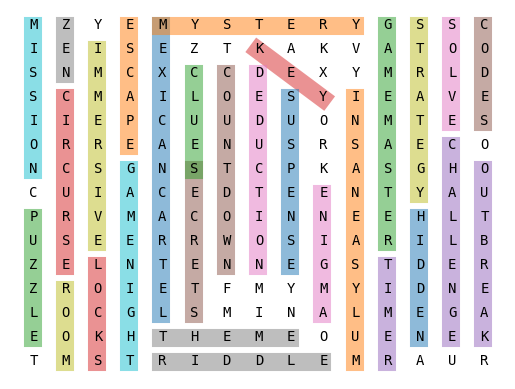

In [1]:
from abc import ABC, abstractmethod

import re
import numpy as np
from dataclasses import dataclass
import matplotlib.pyplot as plt


input_text = """
MZYEMYSTERYGSSC
IEISEZTKAKVATOO
SNMCXCCDEXYMRLD
SCMAILOESYIEAVE
IIEPCUUDUONMTES
ORREAENUSRSAECO
NCSGNSTCPKASGHO
CUIACEDTEENTYAU
PRVMACOINNEEHLT
USEERRWOSIARILB
ZELNTENNEGSTDER
ZROIETFMYMYIDNE
LOCGLSMINALMEGA
EOKHTHEMEOUENEK
TMSTRIDDLEMRAUR
"""


tokens = [
    "Mexican Cartel",
    "Insane Asylum",
    "Game Master",
    "Key",
    "Challenge",
    "Countdown",
    "Deduction",
    "Zen",
    "Immersive",
    "Game Night",
    "Suspense",
    "Mystery",
    "Puzzle",
    "Circurse",
    "Outbreak",
    "Secrets",
    "Enigma",
    "Riddle",
    "Strategy",
    "Mission",
    "Hidden",
    "Escape",
    "Clues",
    "Locks",
    "Timer",
    "Codes",
    "Solve",
    "Theme",
    "Room",
]

plt.rcParams["font.family"] = "monospace"


crossword = []
for line in input_text.strip().split("\n"):
    crossword.append(list(line))

crossword = np.array(crossword)
WIDTH = len(crossword[0])
HEIGHT = len(crossword)

tokens = [token.replace(" ", "").upper() for token in tokens]


@dataclass
class Locator:
    row_start: int
    row_end: int  # inclusive
    col_start: int
    col_end: int  # inclusive

    def array(self):
        return np.array(
            [[self.col_start, self.col_end], [self.row_start, self.row_end]]
        )


def to_diagonal_text(array, other_diagonal=False):
    # Split the block of text into lines
    lines = ["".join(line) for line in array]
    if other_diagonal:
        lines = [list(reversed(l)) for l in lines]

    # Determine the dimensions of the block
    num_lines = len(lines)
    max_length = max(len(line) for line in lines)

    # Create a list to store the diagonal text
    diagonal_text = []

    # Iterate through each diagonal "layer"
    for layer in range(num_lines + max_length - 1):
        line = []
        # Iterate through each row in the diagonal "layer"
        for i in range(num_lines):
            j = layer - i
            if j >= 0 and j < len(lines[i]):
                line.append(lines[i][j])
        if line:
            diagonal_text.append("".join(line))
    return diagonal_text


def draw_box(text):
    lines = text.splitlines()
    width = max(len(line) for line in lines)
    top_border = "┌" + "─" * (width + 2) + "┐"
    bottom_border = "└" + "─" * (width + 2) + "┘"
    body = "\n".join(f"│ {line.ljust(width)} │" for line in lines)
    return f"{top_border}\n{body}\n{bottom_border}"


def to_textblock(array, join_char=""):
    return "\n".join([join_char.join(row) for row in array])


def pretty_print_array(array):
    if array.dtype == bool:
        # convert to single character array
        text_bolck = (
            to_textblock(array.astype(int).astype(str), join_char=" ")
            .replace("0", " ")
            .replace("1", "#")
        )
    else:
        text_bolck = to_textblock(array, join_char=" ")
    print(draw_box(text_bolck))


BOOL_MASK = np.zeros(crossword.shape, dtype=bool)


class AbstractLocator(ABC):

    @abstractmethod
    def to_searchable_line_array(result): ...

    @abstractmethod
    def search_result_to_original_coordinate(result): ...


class LocatorHorziontal:
    to_searchable_line_array = lambda _, text_array: text_array

    @staticmethod
    def search_result_to_original_coordinate(result):
        return Locator(result[0], result[0], result[1].start(), result[1].end() - 1)


class LocatorVertical(LocatorHorziontal):
    to_searchable_line_array = lambda _, text_array: text_array.T

    @staticmethod
    def search_result_to_original_coordinate(result):
        return Locator(result[1].start(), result[1].end() - 1, result[0], result[0])


class LocatorTopRight2BottomLeft:

    def to_searchable_line_array(self, text_array):
        self.diagonal_text = to_diagonal_text(text_array)
        return self.diagonal_text

    def search_result_to_original_coordinate(self, result):
        # this min 'switch' from top boarder to right boarder as diagonal text is taller.
        row_i = min(result[0], HEIGHT - 1)
        # row_i = min(result[0], WIDTH - 1)
        col_j = result[0] - row_i

        _start = len(self.diagonal_text[result[0]]) - result[1].start()
        _end = len(self.diagonal_text[result[0]]) - result[1].end()
        locator = Locator(
            row_i - _start + 1,
            row_i - _end,
            col_j + _start - 1,
            col_j + _end,
        )
        return locator


class LocatorTopLeft2BottomRight(LocatorTopRight2BottomLeft):

    def to_searchable_line_array(self, text_array):
        self.diagonal_text = to_diagonal_text(text_array, other_diagonal=True)
        return self.diagonal_text

    def search_result_to_original_coordinate(self, result):
        # this min 'switch' from top boarder to left boarder as diagonal text is taller.
        col_i = min(result[0], WIDTH - 1)
        col_i = WIDTH - col_i - 1
        row_j = max(0, result[0] - WIDTH + 1)

        _start = result[1].start()
        _end = result[1].end()
        return Locator(
            row_j + _start,
            row_j + _end - 1,
            col_i + _start,
            col_i + _end - 1,
        )


def locate_token(text_array, token):

    for LocatorMethod in (
        LocatorHorziontal,
        LocatorVertical,
        LocatorTopRight2BottomLeft,
        LocatorTopLeft2BottomRight,
    ):
        method = LocatorMethod()
        # convert original text into the corresponding orientation
        line_array = method.to_searchable_line_array(text_array)
        # search for the given token in the given array
        for i, line in enumerate(line_array):
            res = re.search(token, "".join(line))
            if res is not None:
                return method.search_result_to_original_coordinate((i, res))

    raise RuntimeError(f"Failed to find token: {token}")


def get_word_mask(locator: Locator):
    bool_mask = BOOL_MASK.copy()
    if (locator.row_end == locator.row_start) or (locator.col_end == locator.col_start):
        bool_mask[
            locator.row_start : locator.row_end + 1,
            locator.col_start : locator.col_end + 1,
        ] = True
    else:
        # fallback to looping, as this is likely to be a diagonal line, and the above slicing method
        # would produce a block.
        if abs(locator.row_end - locator.row_start) != abs(
            locator.row_end - locator.row_start
        ):
            raise ValueError(f"The given locator is not a diagonal line: {locator}")
        increment_or_decrement = lambda a, b: 1 if b >= a else -1
        i = locator.row_start
        j = locator.col_start
        while i <= locator.row_end:
            bool_mask[i, j] = True
            i += increment_or_decrement(locator.row_start, locator.row_end)
            j += increment_or_decrement(locator.col_start, locator.col_end)
    return bool_mask


accumulate_boolmask = BOOL_MASK.copy()

SEARCH_REVERSED = True
SEARCH_REVERSED = False
if SEARCH_REVERSED:
    # this add all token with its reverse variants, which essentially search in all other directions.
    tokens.extend(["".join(reversed(token)) for token in tokens])

all_locators = []
missing = []
for token in tokens:
    try:
        all_locators.append(locate_token(crossword, token))
    except RuntimeError as e:
        missing.append(token)
        pass

for locator in all_locators:
    accumulate_boolmask = accumulate_boolmask | get_word_mask(locator)

crossword_masked_out = crossword.copy()
crossword_masked_out[accumulate_boolmask] = " "
pretty_print_array(crossword)
pretty_print_array(crossword_masked_out)
if missing:
    print(f"WARN ==== ^ The above map does not accounts for {missing} ====")

###################################################################################
# plot it in matplotlib

canvas_multiplier = 0.07

for i in range(WIDTH):
    for j in range(HEIGHT):
        w = crossword[j, i]
        coordinate = np.array([i, j])
        plt.text(*coordinate * canvas_multiplier, f"{w}")

for locator in all_locators:
    coor = locator.array().astype(float)
    coor[1, :] -= 0.1
    coor[0, :] += 0.1
    plt.plot(*(coor * canvas_multiplier), linewidth=13.0, alpha=0.5)

plt.xticks([])
plt.yticks([])

plt.gca().invert_yaxis()
plt.gca().axis("off")
None

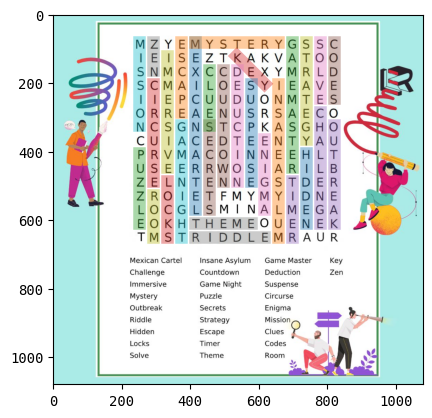

In [3]:
import sys

sys.path.insert(0, "..")
import plotting_utils


canvas_offset = np.array([5.8, 2.35])
canvas_multiplier = 40.61

plt.imshow(plt.imread("../data/Labyrinth-poster.jpg"))

for locator in all_locators:
    coor = locator.array().astype(float) + canvas_offset[:, None]
    coor[1, :] -= 0.39
    coor[0, :] += 0.39
    plt.plot(*(coor * canvas_multiplier), linewidth=9.0, alpha=0.4)

plt.show()
# plotting_utils.save_tight_image("puzzle.jpg", dpi=200)